# 3.4 - Batch normalization

In [3]:
!pip install tensorflow==2.8.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 31.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: goo

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False);

replicating local resources


In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%load_ext tensorboard

from sklearn.datasets import *
from local.lib import mlutils
tf.__version__

'2.8.1'



## Covariate shift

Change of distribution of input to a function:

- in input data it happens when using new data
- in intermediate layers happens **ALSO** when previous layers change weights when training.


## Covariate shift during training

Observe how we use TF Low Level API and custom optimization to see the covariate shift during training

- this could have been done also with the high level API and custom tensorboard summarizers

**We are using again a small dataset based on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)**

In [5]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

--2024-09-14 21:55:35--  https://s3.amazonaws.com/rlx/mini_cifar.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.82.54, 52.216.153.174, 52.216.93.45, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.82.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14803609 (14M) [binary/octet-stream]
Saving to: ‘mini_cifar.h5’

mini_cifar.h5       100%[===================>]  14.12M  --.-KB/s    in 0.1s    

2024-09-14 21:55:35 (110 MB/s) - ‘mini_cifar.h5’ saved [14803609/14803609]



In [6]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

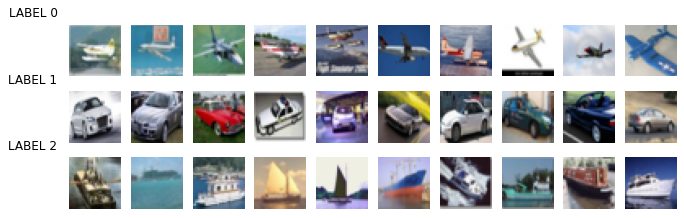

In [ ]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [7]:
print(np.min(x_cifar), np.max(x_cifar))

0.0 1.0


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
num_classes = len(np.unique(y_train))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())
print("\nnum classes", num_classes)
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)



(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    768
0    756
1    729
Name: count, dtype: int64

distribution of test classes
2    257
0    249
1    245
Name: count, dtype: int64

num classes 3


flatten data

In [10]:
x_trainf = np.r_[[i.flatten() for i in x_train]]
x_testf  = np.r_[[i.flatten() for i in x_test]]
x_trainf.shape, x_testf.shape

((2253, 3072), (751, 3072))

### Set up a model with Keras and train

In [14]:
from tensorflow.keras import Model
from tensorflow.keras.activations import relu, sigmoid, tanh, linear, softmax
from progressbar import progressbar as pbar
from scipy.stats import gaussian_kde

class MyModel(Model):

    def build(self, input_shape):

        self.w1 = self.add_weight(shape=(input_shape[-1], 100), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b1 = self.add_weight(shape=(100, ), initializer='random_normal', trainable=True, dtype=tf.float32)

        self.w2 = self.add_weight(shape=(100, 3), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b2 = self.add_weight(shape=(3, ), initializer='random_normal', trainable=True, dtype=tf.float32)

    @tf.function
    def get_z1(self, X):
        r = tf.matmul(X,self.w1)+self.b1
        r = r-tf.reduce_mean(r, axis=0)
        r = r/tf.math.reduce_std(r, axis=0)
        return r

    @tf.function
    def get_a1(self, X):
        r = tf.tanh(self.get_z1(X))
        return r

    @tf.function
    def get_z2(self, X):
        a1 = self.get_a1(X)
        r = tf.matmul(a1,self.w2)+self.b2
        return r

    @tf.function
    def get_a2(self, X):
        return softmax(self.get_z2(X))

    @tf.function
    def call(self, X):
        a2 = self.get_a2(X)
        return a2

    @tf.function
    def train_step(self, X,y):
        preds = model(X)
        with tf.GradientTape() as tape:
            loss_value = tf.reduce_mean(self.loss(model(X), y))
        grads = tape.gradient(loss_value, self.trainable_variables)

        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return loss_value

    def fit(self, X,y, epochs=10, batch_size=32):
        self.hloss = []
        self.hz1, self.hz2 = [], []
        self.ha1, self.ha2 = [], []
        for epoch in pbar(range(epochs)):
            idxs = np.random.permutation(len(X))
            for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):

                X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
                y_batch = y[idxs][step*batch_size:(step+1)*batch_size]
                loss_value = self.train_step(X_batch, y_batch)
                self.hz1.append(self.get_z1(X_batch).numpy().flatten())
                self.hz2.append(self.get_z2(X_batch).numpy().flatten())
                self.ha1.append(self.get_a1(X_batch).numpy().flatten())
                self.ha2.append(self.get_a2(X_batch).numpy().flatten())
                self.hloss.append(loss_value)

    def score(self, X, y):
        return np.mean(model.predict(X).argmax(axis=1) == y)

    def plot_hist(self):
        def plot_z_history(s):
            s = s[::5]
            for i,data in enumerate(pbar(s)):
                kde = gaussian_kde(data)
                xrange = np.linspace(np.min(data), np.max(data),100)
                plt.plot(xrange, kde(xrange)-i*.005,
                         color=plt.cm.RdBu(255*i/len(s)),
                         alpha=.5)
            plt.yticks([0,-i*.005], [0,len(model.hz1)]);
            plt.ylabel("step nb")
            plt.xlabel("activation")
            plt.grid();
        plt.figure(figsize=(15,6))
        plt.subplot(231)
        plt.plot(self.hloss); plt.grid(); plt.title("loss"); plt.xlabel("steps")
        plt.subplot(232)
        plot_z_history(self.hz1); plt.title("z1 (BEFORE activation function at layer 1)\nred signals the first epoch")
        plt.subplot(233)
        plot_z_history(self.hz2); plt.title("z2 (BEFORE activation function at layer 2)\nred signals the first epoch")
        plt.subplot(235)
        plot_z_history(self.ha1); plt.title("a1 (AFTER activation function at layer 1)\nred signals the first epoch")
        plt.subplot(236)
        plot_z_history(self.ha2); plt.title("a2 (AFTER activation function at layer 2)\nred signals the first epoch")
        plt.tight_layout()

In [15]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import categorical_crossentropy

100% (20 of 20) |########################| Elapsed Time: 0:00:18 Time:  0:00:18
  0% (0 of 144) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

train accuracy 0.780
test  accuracy 0.671


100% (144 of 144) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (144 of 144) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (144 of 144) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


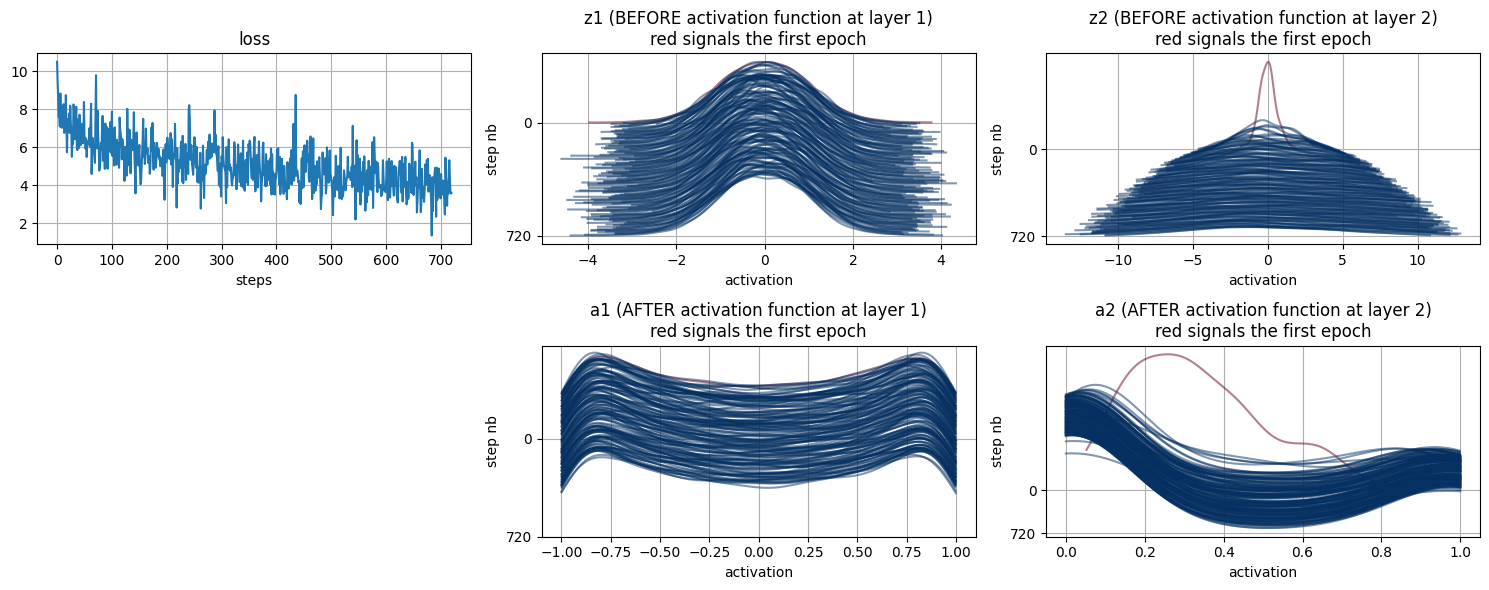

In [16]:
model = MyModel()
model.compile(optimizer="adam", loss=categorical_crossentropy)
model.fit(x_trainf, np.eye(3)[y_train.astype(int)], epochs=20, batch_size=64)
print ("train accuracy %.3f"%model.score(x_trainf, y_train))
print ("test  accuracy %.3f"%model.score(x_testf, y_test))
model.plot_hist()


**Batch Normalizations** fixes the covariate shift:
- just before the linear network output is fed to the activation function
- or just after

Recall the activation of any layer $l$:

$$z^{[l]} = a^{[l-1]}W^{[l]} + b^{[l]}$$
$$a^{[l]} = \text{activation}(z^{[l]})$$

where $a^{[l-1]}$ is the activation (output) of the previous layer, $W^{[l]}$ and $b^{[l]}$ are the layer weights, and $\text{activation}$ is the activation function of that layer (relu, sigmoid, etc.). If layer $l$ has $n_l$ neurons, then $z^{[l]}$ is a vector of $n_l$ elements, just as $b^{[l]}$ and $a^{[l]}$

if we normalize just before the activation function, we normalize $z^{[l]}$ by substracting its mean and dividing by the standard deviation

$$\mu^{[l]} = \frac{1}{n_l}\sum_{i=0}^{n_l-1} z^{[l](i)}$$
$$\sigma^{[l]} = \frac{1}{n_l}\sum_{i=0}^{n_l-1} (z^{[l](i)}-\mu^{[l]})^2$$

so that:

$$\tilde{z}^{[l](i)} = \frac{z^{[l](i)}-\mu^{[l]}}{\sqrt{\sigma^{[l]}+\epsilon}}$$

where, $\epsilon$ is a small number (such as `1e-3`) for numerical stability in case the variace is very close to zero.

**Scaling**

Actually, we allow the normalization to have mean and std different from 0 and 1 respectively.

$$\tilde{z}^{[l](i)} = \gamma^{[l]}\tilde{z}^{[l](i)}+\beta^{[l]}$$

where $\gamma^{[l]}$ and $\beta^{[l]}$ are parameters learnable during training (with gradients, etc.)

**Test data**

When using test data, it might not have much sense to compute $\mu$ and $\sigma$ for small batches (at the extreme the batch size could even be 1, to obtain a prediction for a single data point). In these cases, a running averate of both $\mu$ and $\sigma$  are kept during training and the used in test.

**Other issues**

- BN can be seen as a mild form of regularization, since using $\mu$ and $\sigma$ for every batch introduces some noise during training (such as dropout)

- $\beta^{[l]}$ will subsume the bias parameter of the layer, as they end up being scaled and summed without depending on the data. They both act as constants which can be integrated in a single constant parameter.

See

- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf)

- [Batch normalization: theory and how to use it with Tensorflow](https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad)

- [CS231n Convolutional Neural Networks](http://cs231n.github.io/neural-networks-2/)